[*********************100%***********************]  1 of 1 completed


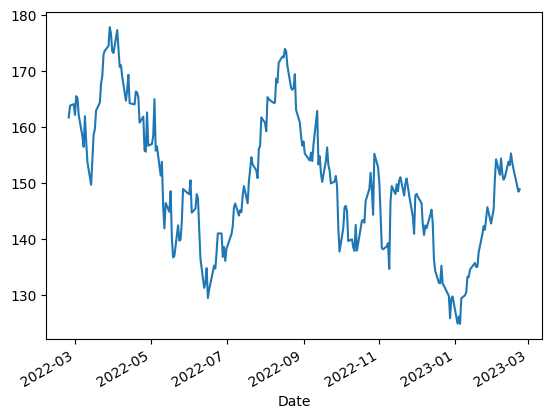

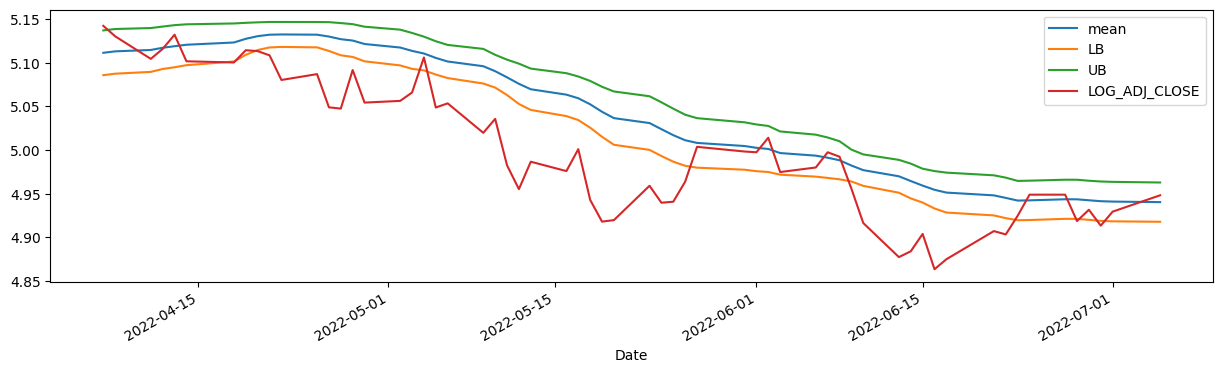

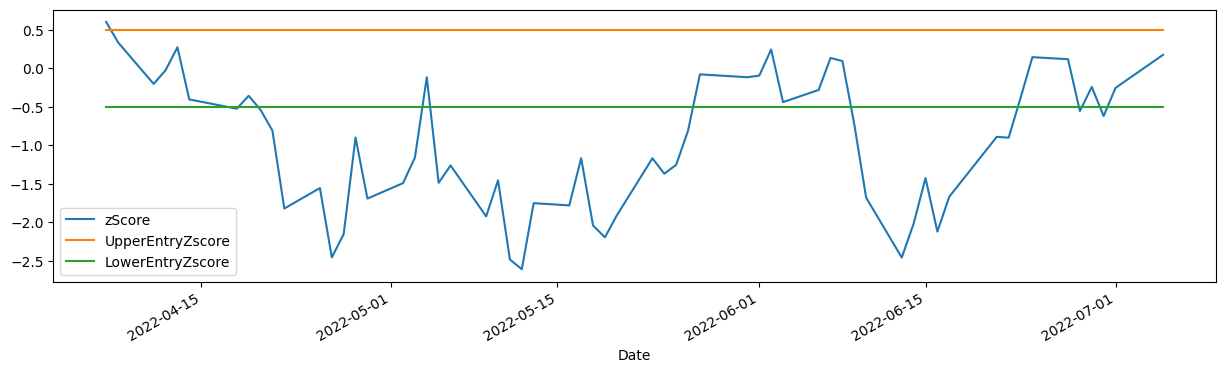

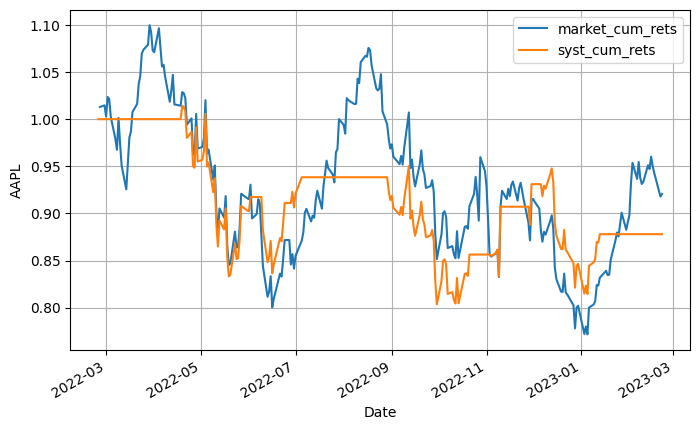

TotaAnnReturn in percent = -12.101346
CAGR in percent = -12.107714
Sharpe Ratio = -0.410000
average return 0.013022
[-0.02003303  0.02112066]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.10460000000000003


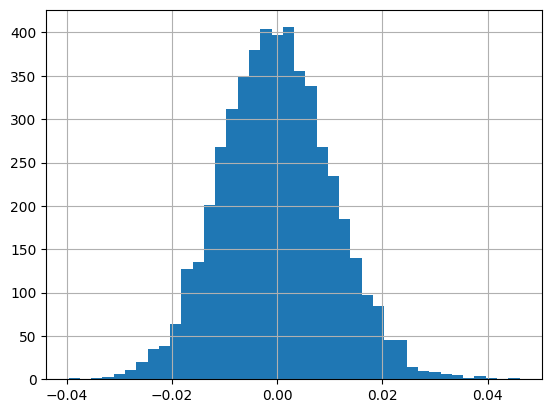

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Fri Aug 17 11:59:11 2018

@author: Rosario
"""
import os
os.getcwd() 
import detrendPrice #you can ignore this fornow
import WhiteRealityCheckFor1 #you can ignore this fornow
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

start_date = '2022-02-24' 
end_date = '2023-02-23' 
#end_date = datetime.now() 


symbol = 'AAPL' 
entryZscore = .5 # gauge of regression channel
exitZscore = -.0
window = 25 #lookback for moving average
shorts = 0 #shorts possible or not
delay = 1 #1 for instant execution, 2 for one day delay
tcost=10/10000*0


msg = "" 
address = symbol + '.csv'
  

try:
    dfP = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
    dfP.to_csv(address, header = True, index=True, encoding='utf-8')
except Exception:
    msg = "yahoo problem"
    dfP = pd.DataFrame()

dfP = pd.read_csv(address, parse_dates=['Date'])
dfP = dfP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)

dfP['Adj Close'].plot()
plt.show()

dfP['LOG_ADJ_CLOSE']= np.log(dfP['Adj Close']) #another way of doing the same thing
#dfP.LOG_ADJ_CLOSE = np.log(dfP['Adj Close']) #another way of doing the same thing? won't work

mean = dfP['LOG_ADJ_CLOSE'].rolling(window=window).mean()

std_dev = dfP['LOG_ADJ_CLOSE'].rolling(window=window).std()

dfP['zScore'] = (dfP['LOG_ADJ_CLOSE']-mean)/std_dev
dfP['mean'] = mean
dfP['stdev'] = std_dev
dfP['LB'] = mean - entryZscore*std_dev
dfP['UB'] = mean + entryZscore*std_dev
dfP['UpperEntryZscore'] = entryZscore
dfP['LowerEntryZscore'] = entryZscore*-1

#dfP['zScore'].plot()
#plt.show()

dfP[30:90].plot(y=["mean", "LB", "UB", "LOG_ADJ_CLOSE"], figsize=(15,4))
dfP[30:90].plot(y=["zScore", "UpperEntryZscore", "LowerEntryZscore"], figsize=(15,4))


#set up num_units_long  
dfP['long_entry'] = ((dfP.zScore <  -entryZscore))
dfP['long_exit'] = ((dfP.zScore >  -exitZscore))

dfP['num_units_long'] = np.nan #it is important to start with nan in this column otherwise padding wont work
dfP.loc[dfP['long_entry'],'num_units_long'] = 1 
dfP.loc[dfP['long_exit'],'num_units_long'] = 0 


dfP.iat[0,dfP.columns.get_loc("num_units_long")]= 0
dfP['num_units_long'] = dfP['num_units_long'].fillna(method='pad') 

#set up num units short 
dfP['short_entry'] = ((dfP.zScore >  entryZscore))
dfP['short_exit'] = ((dfP.zScore <  exitZscore))


dfP['num_units_short'] = np.nan #it is important to start with nan in this column otherwise padding wont work
dfP.loc[dfP['short_entry'],'num_units_short'] = -1 
dfP.loc[dfP['short_exit'],'num_units_short'] = 0

dfP.iat[0,dfP.columns.get_loc("num_units_short")]= 0
dfP['num_units_short'] = dfP['num_units_short'].fillna(method='pad')

dfP['stance'] = dfP['num_units_long']*(1-tcost) +  dfP['num_units_short']*shorts*(1-tcost)

#log syst return calculation & cumulative return
#dfP['log_rets'] = np.log(dfP['Adj Close']/dfP['Adj Close'].shift(1))
#dfP['syst_rets'] = dfP['log_rets'] * dfP['stance'].shift(delay) 
#dfP['syst_cum_rets'] = dfP['log_rets'].cumsum() #cumsum is good for log returns only

#pct syst return calculation & cumulative return
dfP['pct_rets'] = (dfP['Adj Close']-dfP['Adj Close'].shift(1))/dfP['Adj Close'].shift(1)
dfP['syst_rets'] = dfP['pct_rets'] * dfP['stance'].shift(delay) 
dfP['syst_cum_rets']= np.cumprod(1+dfP['syst_rets']) -1 

dfP['market_cum_rets'] = np.cumprod(1+dfP['pct_rets'])-1

dfP['syst_cum_rets']= dfP['syst_cum_rets'] + 1 #optional
dfP['market_cum_rets'] = dfP['market_cum_rets'] + 1 #optional

dfP.iat[0,dfP.columns.get_loc('syst_cum_rets')]= 1 #changing nan to 1

title=symbol
#plt.plot(dfP[['market_cum_rets','syst_cum_rets']])
dfP[['market_cum_rets','syst_cum_rets']].plot(grid=True,figsize=(8,5))
plt.ylabel(symbol)
plt.show()
#plt.savefig(r'Results\%s.png' %(title))
#plt['Close']()

start = 1
start_val = start
end_val = dfP['syst_cum_rets'].iat[-1]

start_date = dfP.iloc[0].name
end_date = dfP.iloc[-1].name
days = (end_date - start_date).days    


periods = 360 #360 accounting days
trading_periods = 252 #252 trading days

TotaAnnReturn = (end_val-start_val)/start_val/(days/periods)
TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/trading_periods)

years = days/periods
CAGR = ((end_val/start_val)**(1/years))-1
      
try:
    sharpe =  (dfP['syst_rets'].mean()/dfP['syst_rets'].std()) * np.sqrt(periods)
except ZeroDivisionError:
    sharpe = 0.0

print ("TotaAnnReturn in percent = %f" %(TotaAnnReturn*100))
print ("CAGR in percent = %f" %(CAGR*100))
print ("Sharpe Ratio = %f" %(round(sharpe,2)))

#white reality check
#Detrending Prices and Returns and white reality check
dfP['Det_Adj_Close'] = detrendPrice.detrendPrice(dfP['Adj Close']).values #you can ignore this for now
dfP['Det_pct_rets'] = (dfP['Det_Adj_Close']-dfP['Det_Adj_Close'].shift(1))/dfP['Det_Adj_Close'].shift(1) #you can ignore this for now
dfP['Det_syst_rets'] = dfP['Det_pct_rets'] * dfP['stance'].shift(delay) #you can ignore this for now
WhiteRealityCheckFor1.bootstrap(dfP['Det_syst_rets'])#you can ignore this for now

    
dfP.to_csv(r'Results\dfP_Simple.csv', header = True, index=True, encoding='utf-8')
